In [40]:
import numpy as np
import matplotlib.pyplot as plt

In [41]:
%reload_ext autoreload
%autoreload 2

In [42]:
namesngenre = np.load('./dataset/namesngenre.npy')

In [43]:
namesngenre

array([['Toy Story (1995)',
        'Adventure|Animation|Children|Comedy|Fantasy'],
       ['Jumanji (1995)', 'Adventure|Children|Fantasy'],
       ['Grumpier Old Men (1995)', 'Comedy|Romance'],
       ...,
       ['Elsa & Fred (2005)', 'Comedy|Drama|Romance'],
       ['Tomb Raider (2018)', 'Action|Adventure|Fantasy'],
       ['Fred Armisen: Standup for Drummers (2018)', 'Comedy']],
      dtype='<U158')

In [44]:
ratings_train = np.load('./dataset/ratings_train.npy')

In [45]:
ratings_train.shape

(610, 4980)

In [46]:
ratings_train

array([[ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan,  2., nan, ..., nan, nan, nan],
       [ 3., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [47]:
np.nanmax(ratings_train)


5.0

In [48]:
np.nanmin(ratings_train)

0.5

# Matrix Factorization

In [49]:
import MF

In [50]:
k = 1

factorization = MF.MF(ratings_train, l=0.01, mu=0.01, k=k)


In [51]:
non_nan_indices = np.where(~np.isnan(ratings_train))
print(non_nan_indices)
# Separate the row and column indices
row_indices, col_indices = non_nan_indices
R_non_nan = factorization.R[row_indices, col_indices]

(array([  0,   0,   0, ..., 609, 609, 609], dtype=int64), array([   0,   44,   58, ..., 4928, 4929, 4937], dtype=int64))


In [52]:
factorization.fit(lr_I=0.0001, lr_U=0.0001, num_iterations=100)
prediction_full = factorization.predict()
prediction = prediction_full[row_indices, col_indices]
print(prediction)
factorization.RMSE_(prediction_full)

Iteration 1: Cost = 32392.999775727294. RMSE = 1.0094178556936002
Iteration 2: Cost = 31379.13921235615. RMSE = 0.9933969755194786
Iteration 3: Cost = 30618.05845467384. RMSE = 0.9811983620094424
Iteration 4: Cost = 30009.30220732772. RMSE = 0.9713307438572282
Iteration 5: Cost = 29502.756415628777. RMSE = 0.9630426867605009
Iteration 6: Cost = 29070.13009088203. RMSE = 0.9559070809645166
Iteration 7: Cost = 28693.74438039374. RMSE = 0.9496553845545416
Iteration 8: Cost = 28361.6839916821. RMSE = 0.9441054790234434
Iteration 9: Cost = 28065.46999072267. RMSE = 0.9391269580102453
Iteration 10: Cost = 27798.824657134937. RMSE = 0.934622676738243
Iteration 11: Cost = 27556.95734882301. RMSE = 0.9305180618239591
Iteration 12: Cost = 27336.123155609286. RMSE = 0.9267544853716159
Iteration 13: Cost = 27133.336150502648. RMSE = 0.9232849455999945
Iteration 14: Cost = 26946.175841176915. RMSE = 0.9200711413645253
Iteration 15: Cost = 26772.652478989065. RMSE = 0.917081429536286
Iteration 16: C

0.8384281041625187

0.8998834238908144


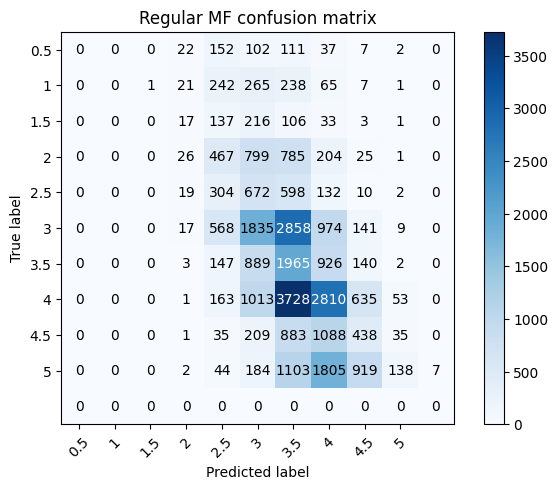

Accuracy: 23.79%


In [62]:
targets = np.load('./dataset/ratings_test.npy')
targets[np.isnan(targets)] = 0

predictions = np.round(prediction_full * 2)/2
rmse_value = RMSE(targets, predictions) 

print(rmse_value)
plot_cm(targets, predictions, title='Regular MF confusion matrix')
# Calculate the accuracy
correct_predictions = np.sum(targets[targets!=0] == predictions[targets!=0])
total_predictions = len(targets[targets!=0])

accuracy = correct_predictions / total_predictions

print(f"Accuracy: {accuracy * 100:.2f}%")

# Deep Matrix Factorization


In [ ]:
import deepMF
import torch
import torch.nn as nn
import torch.optim as optim
%reload_ext autoreload
%autoreload 2

In [ ]:
# Load the input data from a numpy file
ratings_train = np.load('dataset/ratings_train.npy')
ratings_test = np.load('dataset/ratings_test.npy')
# Replace NaN values with 0
ratings_train[np.isnan(ratings_train)] = 0
ratings_test[np.isnan(ratings_test)] = 0

In [ ]:
total_data = ratings_train + ratings_test

non_empty_indices = np.where(total_data != 0)
non_empty_indices = np.array([non_empty_indices[0], non_empty_indices[1]])

indices = np.random.choice(np.array(range(non_empty_indices.shape[1])), size=non_empty_indices.shape[1], replace = False)

train_set_indices = indices[0:int(non_empty_indices.shape[1]*0.7)]
train_set_indices2d = np.array(non_empty_indices[:, train_set_indices])
train_set = np.zeros(total_data.shape)
train_set[train_set_indices2d[0], train_set_indices2d[1]] = total_data[train_set_indices2d[0], train_set_indices2d[1]]

test_set_indices = indices[int(non_empty_indices.shape[1]*0.7):]
test_set_indices2d = np.array(non_empty_indices[:, test_set_indices])
test_set = np.zeros(total_data.shape)
test_set[test_set_indices2d[0], test_set_indices2d[1]] = total_data[test_set_indices2d[0], test_set_indices2d[1]]

normalized_train_data = train_set/np.max(train_set)

normalized_test_data = test_set/np.max(test_set)

In [ ]:
# Hyperparameters evaluation
encoded_dim = 32
input_size = normalized_train_data.shape 
hidden_size_row = 16
hidden_size_col = 64

In [63]:
import time

In [64]:
# Start the timer
start_time = time.time()
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
deepMF.train_model(model, optimizer, torch.FloatTensor(normalized_train_data), test_data=test_set)
# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time} seconds")

2993563
Elapsed time: 49.58657670021057 seconds


[1.8090029954910278, 1.518591046333313, 1.2772815227508545, 1.091922402381897, 0.9572230577468872, 0.8762134313583374, 0.8367995619773865, 0.8229821920394897, 0.8218688368797302, 0.8224519491195679, 0.8196720480918884, 0.8119210600852966, 0.8003397583961487, 0.7900006771087646, 0.7824667692184448, 0.7808458209037781, 0.7824122309684753, 0.7842073440551758, 0.7834173440933228, 0.7816700339317322, 0.7796587944030762, 0.7785606980323792, 0.7791494727134705, 0.7806158065795898, 0.7812602519989014, 0.7800217270851135, 0.7767158150672913, 0.7721425294876099, 0.7673644423484802, 0.7630724906921387, 0.75959712266922, 0.7566437721252441, 0.7537275552749634, 0.7507810592651367, 0.7479670643806458, 0.7455202341079712, 0.7436509728431702, 0.7425235509872437, 0.742059051990509, 0.7420749068260193, 0.7418891787528992, 0.7408671379089355, 0.7387839555740356, 0.7358809113502502, 0.7327429056167603, 0.7297643423080444, 0.7272637486457825, 0.725273847579956, 0.7237353920936584, 0.7225996851921082, 0.721

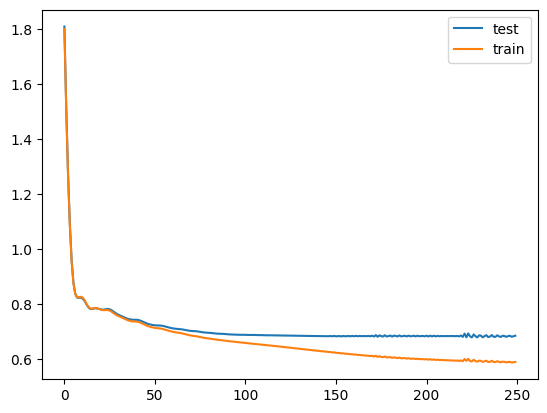

In [ ]:
print(model.rmse_test_hist)
print(model.rmse_train_hist)
plt.plot(model.rmse_test_hist, label="test")
plt.plot(model.rmse_train_hist, label="train")
plt.legend()

## Result analysis

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [70]:
!python generate.py --name ./dataset/ratings_train.npy

Ratings loading...
Ratings Loaded.


In [71]:
def plot_cm(targets, predictions, model=None, title='Confusion Matrix'):  
    predictions = predictions[targets!=0]
    targets = targets[targets!=0]
    predictions_strings  = [str(prediction) for prediction in predictions]
    targets_strings  = [str(target) for target in targets]
    # Compute the confusion matrix
    cm = confusion_matrix(targets_strings, predictions_strings)
    
    # Display the confusion matrix as a heatmap
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    if (model is not None):
        plt.title(f"Confusion Matrix, num_epochs={model.num_epochs}, encoded_dim='{model.encoded_dim}'")
    else: 
        plt.title(title)
    
    plt.colorbar()
    
    classes = ['0.5', '1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5']  # Replace with your class labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [72]:
def RMSE(targets, predictions):
    predictions = predictions[targets!=0]
    targets = targets[targets!=0]
    # Calculate the squared differences between predictions and targets
    squared_errors = (predictions - targets) ** 2

    # Calculate the mean of squared errors
    mean_squared_error = squared_errors.mean()

    # Calculate the square root to get RMSE
    return np.sqrt(mean_squared_error)

0.9590976728664575


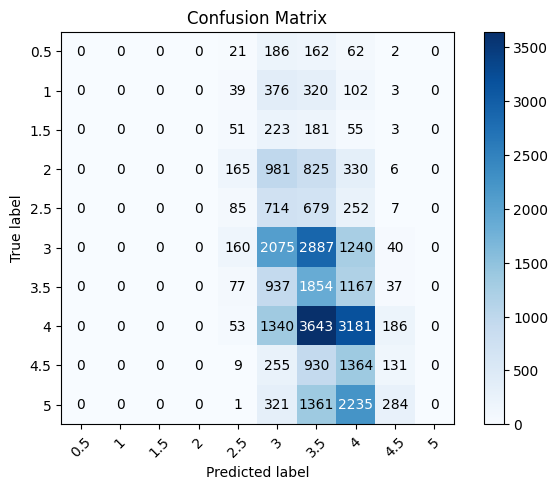

In [73]:
"""
    Use thise cell after running generate.py and assign the used file to calculate the train rmse.

    To have the test RMSE use the test file.
"""

targets = np.load('./dataset/ratings_test.npy')
targets[np.isnan(targets)] = 0

predictions = np.load('output.npy')
rmse_value = RMSE(targets, predictions) 

print(rmse_value)
plot_cm(targets, predictions)


0.8999185917285617


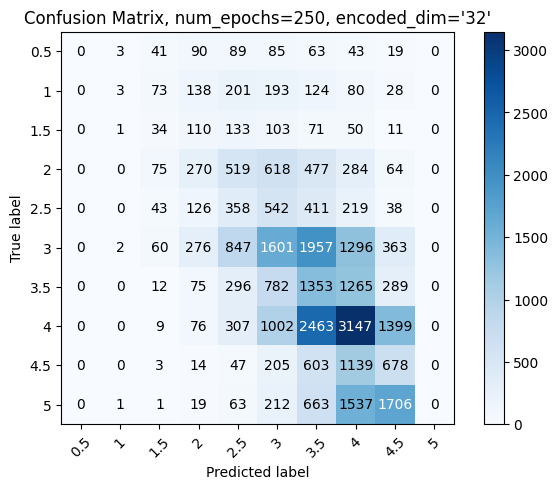

[2.2954814434051514, 2.072282075881958, 1.8701590299606323, 1.7116366624832153, 1.584389567375183, 1.477867841720581, 1.3855957984924316, 1.304055094718933, 1.2305419445037842, 1.165701985359192, 1.1097536087036133, 1.0640803575515747, 1.032084584236145, 1.013519287109375, 1.0063141584396362, 1.007544994354248, 1.012459397315979, 1.0176676511764526, 1.0212782621383667, 1.0222532749176025, 1.0208237171173096, 1.0176829099655151, 1.0140371322631836, 1.0111331939697266, 1.0092592239379883, 1.0085089206695557, 1.0083736181259155, 1.0074710845947266, 1.0052505731582642, 1.0019859075546265, 0.9984480738639832, 0.9954726696014404, 0.9933700561523438, 0.9918293356895447, 0.9903318285942078, 0.9885360598564148, 0.9863374829292297, 0.9840647578239441, 0.9819043874740601, 0.9801068305969238, 0.9787012338638306, 0.9774044752120972, 0.9760356545448303, 0.9745681881904602, 0.9730939865112305, 0.9716911315917969, 0.9703589677810669, 0.9691670536994934, 0.9680848121643066, 0.96700119972229, 0.96587717

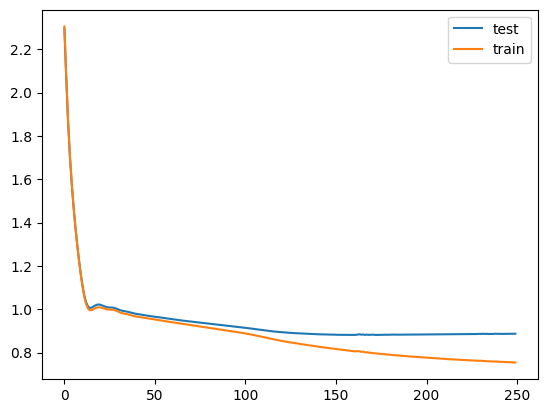

In [81]:
train_set = np.load('./dataset/ratings_train.npy')

train_set[np.isnan(train_set)] = 0
train_set = train_set/np.max(train_set)

test_set = np.load('./dataset/ratings_test.npy')
test_set[np.isnan(test_set)] = 0
encoded_dim = 32
input_size = train_set.shape 
hidden_size_row = 16
hidden_size_col = 64
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col, encoded_dim)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
deepMF.train_model(model, optimizer, torch.FloatTensor(train_set), num_epochs=250, lambda_=10, mu_=10, test_data=test_set)
predicted, _, _ = model(torch.FloatTensor(train_set), torch.FloatTensor(train_set).T) 

targets = np.load('./dataset/ratings_test.npy')
targets[np.isnan(targets)] = 0

predictions = model.numpy_and_round(predicted)
rmse_value = RMSE(targets, predictions) 

print(rmse_value)
plot_cm(targets, predictions, model)
print(model.rmse_test_hist)
print(model.rmse_train_hist)
plt.plot(model.rmse_test_hist, label="test")
plt.plot(model.rmse_train_hist, label="train")
plt.legend()



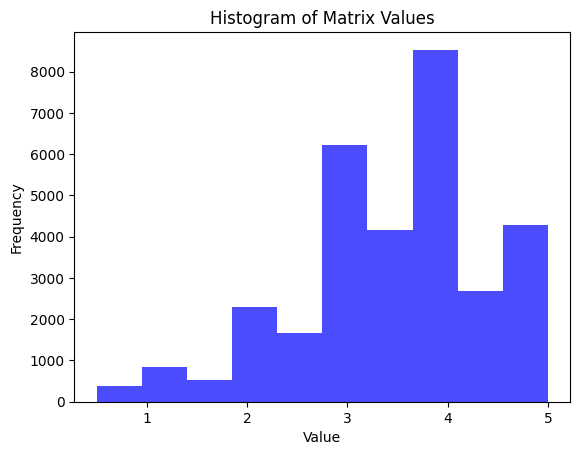

Mean (mu): 3.524605987720742
Standard Deviation (sigma): 1.0326053351746378


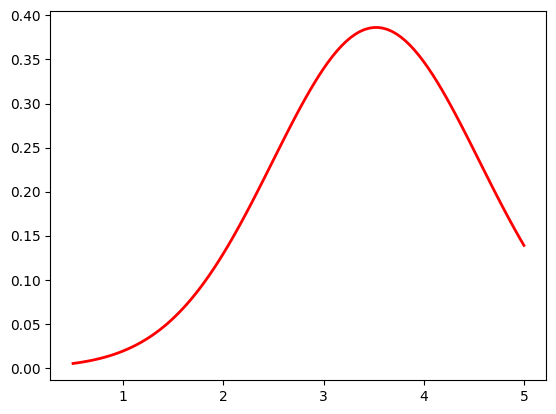

In [ ]:
from scipy.stats import norm, fit
# Create the x-axis values for the normal distribution curve
# Flatten the matrix to a 1D array to create the histogram
values = ratings_train.flatten()
values = values[~np.isnan(values)]
# Fit a normal distribution to the histogram
mu, std = norm.fit(values)

# Set the number of bins for the histogram
num_bins = 10

# Create the histogram plot
plt.hist(values, bins=num_bins,color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Matrix Values')
plt.show()
x = np.linspace(min(values), max(values), 100)
pdf = norm.pdf(x, mu, std)

# Plot the histogram
plt.plot(x, pdf, 'r-', linewidth=2)

# Print the parameters of the best-fit normal distribution
print(f"Mean (mu): {mu}")
print(f"Standard Deviation (sigma): {std}")

# PCA 

### Just for analysis


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
output = np.load('output.npy')
non_normalized_train_data = np.load('./dataset/ratings_train.npy')
non_normalized_train_data[np.isnan(non_normalized_train_data)] = 0
rmse_per_user = []
for line_output, line_test in zip(output, non_normalized_train_data):
    predictions = line_output[line_test!=0]
    targets = line_test[line_test!=0]
    # Calculate the squared differences between predictions and targets
    squared_errors = (predictions - targets) ** 2

    # Calculate the mean of squared errors
    mean_squared_error = squared_errors.mean()

    # Calculate the square root to get RMSE
    rmse_value = np.sqrt(mean_squared_error)
    rmse_per_user.append(rmse_value)
rmse_per_user = np.array(rmse_per_user)
print(rmse_per_user)

[0.74823737 0.80178373 2.39390251 1.13231747 0.73764331 0.85376558
 1.18465568 0.85391256 1.0567245  1.01884419 0.67082039 1.11803399
 0.84983659 1.03077641 1.11156508 0.56796183 0.56229571 0.45003516
 0.80664096 0.93464604 0.91324498 1.79362908 0.63671454 0.50591737
 0.48181206 0.66666667 1.12258812 0.81679322 0.42257713 0.90138782
 0.98952851 0.64199857 0.87979456 1.1697953  0.93541435 1.12232588
 1.27475488 1.09653133 0.85723304 0.79296146 1.02817453 0.88376155
 0.82693623 0.90138782 0.82741488 0.5        1.23743687 0.65828059
 0.44095855 0.61129715 0.97681455 0.68978725 1.28695377 0.62360956
 1.6507574  0.59603956 0.76603235 0.87876176 0.88795357 0.80178373
 0.74535599 0.66475665 0.815923   0.66373849 0.51754917 0.62931678
 0.55097317 0.87697701 0.79056942 0.55167728 1.03077641 0.42640143
 0.94146887 0.53393606 1.18321596 1.34688625 1.5411035  1.03509834
 0.68599434 0.44607129 1.05220856 0.89732648 0.96824584 0.66757185
 1.11803399 0.52859414 0.61237244 0.47140452 1.13767473 0.7254

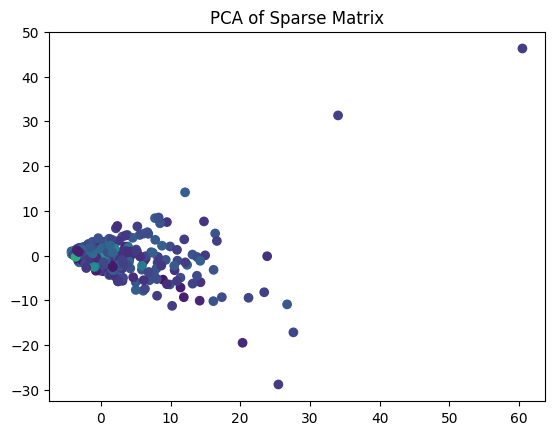

In [ ]:
# Generate a random sparse matrix
X = non_normalized_train_data = np.load('./dataset/ratings_train.npy')
X[np.isnan(X)] = 0

n_samples = X.shape[0]
n_features = X.shape[1]

# Perform PCA
n_components = 2  # Number of components to retain
pca = PCA(n_components=n_components)
X_r = pca.fit_transform(X)

# Plot the results
fig = plt.figure()
plt.scatter(X_r[:, 0], X_r[:, 1], c=rmse_per_user)
plt.title('PCA of Sparse Matrix')
plt.show()


tensor(0.0091, grad_fn=<AddBackward0>)
tensor(0.0086, grad_fn=<AddBackward0>)
tensor(0.0082, grad_fn=<AddBackward0>)
tensor(0.0079, grad_fn=<AddBackward0>)
tensor(0.0076, grad_fn=<AddBackward0>)
tensor(0.0074, grad_fn=<AddBackward0>)
tensor(0.0072, grad_fn=<AddBackward0>)
tensor(0.0070, grad_fn=<AddBackward0>)
tensor(0.0068, grad_fn=<AddBackward0>)
tensor(0.0067, grad_fn=<AddBackward0>)
tensor(0.0066, grad_fn=<AddBackward0>)
tensor(0.0065, grad_fn=<AddBackward0>)
tensor(0.0064, grad_fn=<AddBackward0>)
tensor(0.0064, grad_fn=<AddBackward0>)
tensor(0.0064, grad_fn=<AddBackward0>)
tensor(0.0063, grad_fn=<AddBackward0>)
tensor(0.0063, grad_fn=<AddBackward0>)
tensor(0.0063, grad_fn=<AddBackward0>)
tensor(0.0063, grad_fn=<AddBackward0>)
tensor(0.0063, grad_fn=<AddBackward0>)
tensor(0.0063, grad_fn=<AddBackward0>)
tensor(0.0063, grad_fn=<AddBackward0>)
tensor(0.0063, grad_fn=<AddBackward0>)
tensor(0.0062, grad_fn=<AddBackward0>)
tensor(0.0062, grad_fn=<AddBackward0>)
tensor(0.0062, grad_fn=<A

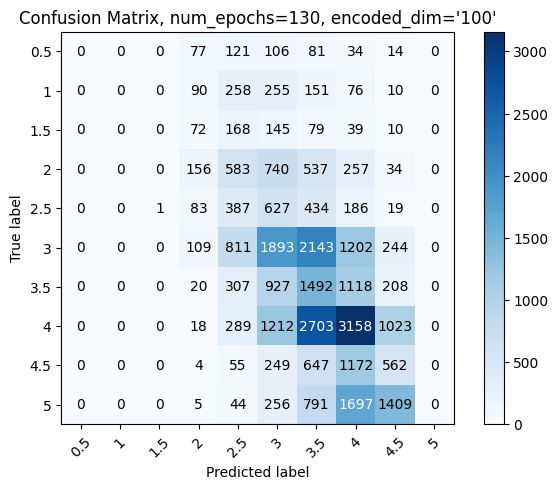

In [ ]:
train_set = np.load('./dataset/ratings_train.npy')

train_set[np.isnan(train_set)] = 0
train_set = train_set/np.max(train_set)
test_set = np.load('./dataset/ratings_test.npy')
test_set[np.isnan(test_set)] = 0
encoded_dim = 100
input_size = train_set.shape 
hidden_size_row = 16
hidden_size_col = 64
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col, encoded_dim)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)
deepMF.train_model(model, optimizer, torch.FloatTensor(train_set), num_epochs=130, lambda_=0, mu_=0)
predicted, _, _ = model(torch.FloatTensor(train_set), torch.FloatTensor(train_set).T) 
targets = test_set
targets[np.isnan(targets)] = 0

predictions = model.numpy_and_round(predicted)
rmse_value = RMSE(targets, predictions) 

print(rmse_value)
plot_cm(targets, predictions, model)
